In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from inpainting_tools import *
import pickle

Lecture de l'image : 

In [2]:
imdata = read_im("images/house.jpg")

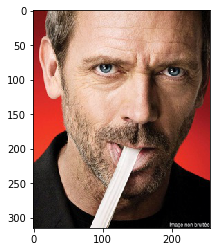

In [3]:
show_im(imdata)

Nous considérons des patchs de côtés de longueur 3 :

In [4]:
h = 3

### 1) Test sur un dictionnaire issu de l'image complète sans bruit

Construction du dictionnaire issu de l'image complète sans bruit :

In [5]:
dictionary = get_dictionary(imdata,h)

Choix arbitraire du patch dont le pixel du bord en haut à gauche a pour coordonnées (30,21) :

In [6]:
patch1 = get_patch(30, 21, h, imdata)

Transformation en vecteur du patch et en matrice du dictionnaire :

In [7]:
vect1, X1, _ = compute_vectors_for_optimization(patch1, dictionary)

Pour plusieurs valeurs de $\alpha$, nous calculons :
- le vecteur de poids w sur le dictionnaire qui approxime au mieux le patch
- la combinaison linéaire correspondante, i.e. la prédiction du modèle 
- l'erreur aux moindres carrés avec pénalisation L1
- la pénalisation L1 associée

In [8]:
n_alphas = 20
alphas = np.logspace(-5, 2, n_alphas)

ground_truth = from_patch_to_vect(patch1)
coefs = []
predictions = []
errors = []
penalties = []

for a in alphas:
    w = compute_weights_for_patch(vect1, X1, alpha=a)
    pred = np.dot(X1.T, w)
    coefs.append(w)
    predictions.append(pred)
    errors.append(loss(pred, ground_truth, w, a))
    penalties.append(np.linalg.norm(w, ord=1))

/home/arij/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


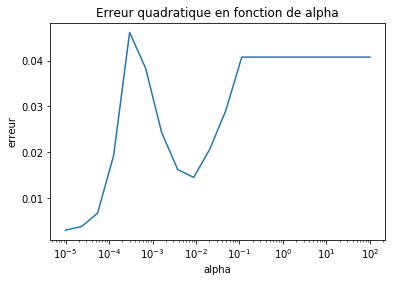

In [9]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.title('Erreur quadratique en fonction de alpha')
plt.axis('tight')
plt.show()

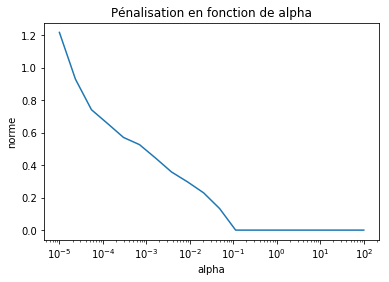

In [10]:
ax = plt.gca()

ax.plot(alphas, penalties)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('norme')
plt.title('Pénalisation en fonction de alpha')
plt.axis('tight')
plt.show()

### Test sur un dictionnaire issu d'une image bruitée

Nous bruitons maintenant un certain nombre de pixels (10% de l'image) :

In [11]:
noisy_im = noise(imdata, 10)

Affichage de l'image :

/home/arij/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


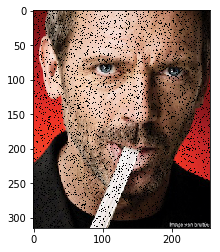

In [12]:
show_im(noisy_im)

Construction du dictionnaire issu de l'image bruitée :

In [13]:
noisy_dictionary = get_dictionary(noisy_im,h)

#### a. Test sur un patch non bruité

Choix aléatoire d'un patch ne contenant aucun pixel manquant, mais qui n'est pas contenu dans le dictionnaire (car ne faisant pas partie du quadrillage de l'image) :

In [14]:
patch2 = get_random_full_patch(noisy_im,h)

Transformation du vecteur en patch et du dictionnaire en matrice :

In [15]:
vect2, X2, _ = compute_vectors_for_optimization(patch2, noisy_dictionary)

In [16]:
n_alphas = 20
alphas = np.logspace(-5, 2, n_alphas)

ground_truth = from_patch_to_vect(patch2)
coefs = []
predictions = []

errors = []
penalties = []
for a in alphas:
    w = compute_weights_for_patch(vect2, X2, alpha=a)
    pred = np.dot(X2.T, w)
    coefs.append(w)
    predictions.append(pred)
    errors.append(loss(pred, ground_truth, w, a))
    penalties.append(np.linalg.norm(w, ord=1))

/home/arij/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


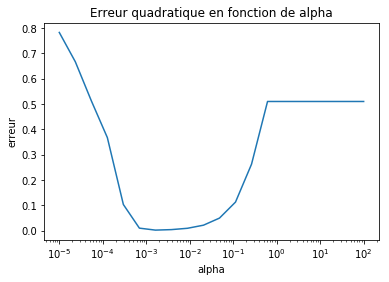

In [17]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.title('Erreur quadratique en fonction de alpha')
plt.axis('tight')
plt.show()

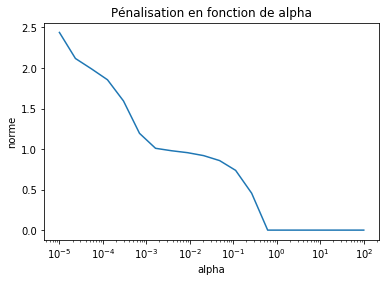

In [18]:
ax = plt.gca()

ax.plot(alphas, penalties)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('norme')
plt.title('Pénalisation en fonction de alpha')
plt.axis('tight')
plt.show()

#### b. Test sur un patch bruité

Récupération de tous les patchs bruités, et des indices des pixels au centre correspondant :

In [19]:
noisy_patches, ind_centers_missing = get_missing_pixel_patches(noisy_im, 3)

Nous choisissons arbitrairement le premier patch de la liste :

In [20]:
patch3 = noisy_patches[0]
ind3 = ind_centers_missing[0]

Transformation du vecteur en patch et du dictionnaire en matrice, et récupération des indices des pixels manquants dans le patch :

In [21]:
vect3, X3, ind_missing_pixels = compute_vectors_for_optimization(patch3, noisy_dictionary)

Récupération du patch non bruité correspondant :

In [22]:
full_patch3 = get_patch(ind3[0], ind3[1], h, imdata)

Récupération de la matrice complète associée au dictionnaire, pour l'inférence :

In [23]:
full_X3 = X2 

In [24]:
n_alphas = 20
alphas = np.logspace(-5, 2, n_alphas)

ground_truth = from_patch_to_vect(full_patch3)
coefs = []
predictions = []

errors = []
penalties = []
for a in alphas:
    w = compute_weights_for_patch(vect3, X3, alpha=a)
    pred = np.dot(full_X3.T, w)
    coefs.append(w)
    predictions.append(pred)
    errors.append(loss(pred, ground_truth, w, a))
    penalties.append(np.linalg.norm(w, ord=1))

/home/arij/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


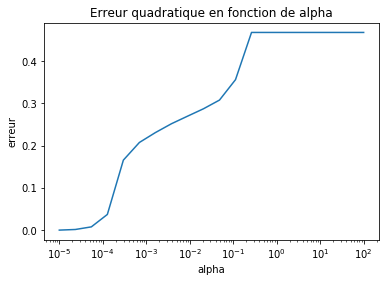

In [25]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.title('Erreur quadratique en fonction de alpha')
plt.axis('tight')
plt.show()

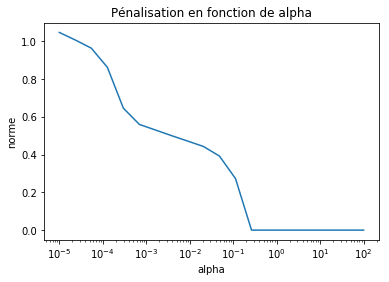

In [26]:
ax = plt.gca()

ax.plot(alphas, penalties)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('norme')
plt.title('Pénalisation en fonction de alpha')
plt.axis('tight')
plt.show()

In [27]:
best_pred = predictions[np.argmin(errors)]

### Remplissage d'une image

In [30]:
height = 315
i = int(h/2)
j = int(h/2)
i_min = (height-i-1)-int(h/2)
i_max = (height-i)+int(h/2)
j_min = j-int(h/2)
j_max = j+int(h/2)+1

In [31]:
i = 100#61
j = 10 #51
height = 10
width = 10

im_missing = delete_rect(imdata, i, j, height, width)

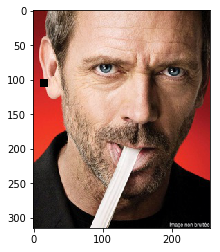

In [32]:
show_im(im_missing)

In [33]:
### pour pouvoir faire un quadrillage l'image
im_missing = im_missing[:,:255,:]

In [34]:
im_missing.shape

(315, 255, 3)

In [35]:
h = 15

In [36]:
dictionary_missing = get_dictionary(im_missing,h)

In [37]:
patches, inds = get_missing_pixel_patches(im_missing, h)

In [39]:
filled_im = fill_image(im_missing, h, dictionary_missing, alpha=10**-2)

/home/arij/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


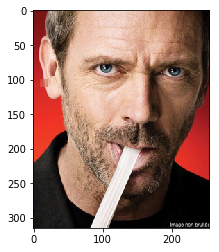

In [40]:
show_im(filled_im)

In [41]:
noisy_im = noise(imdata, 2)

In [42]:
noisy_im = noisy_im[:,:255,:]

/home/arij/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


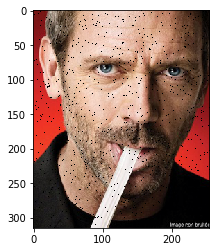

In [43]:
show_im(noisy_im)

In [44]:
h = 3
dictionary_noisy = get_dictionary(noisy_im,h)

In [45]:
filled_im = fill_image(noisy_im, h, dictionary_noisy, alpha=10**-2,max_iter=100000)

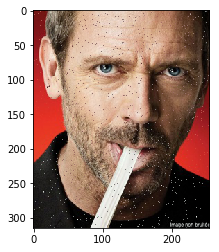

In [46]:
show_im(filled_im)

On remarque la difficulté d'approximer des pixels isolés et que une petite taille de patch est necessaire pour les images buitées